## 8. Google trends

https://www.data-to-viz.com/

https://github.com/cristianpjensen/stock-market-prediction-via-google-trends#data_collection
https://github.com/le0x99/DailyTrends  

### 0. Import modules and load data

In [2]:
# data manipualtion and basics
import pandas as pd
import numpy as np
import time
from datetime import date

import warnings
warnings.filterwarnings('ignore') # ignorar warnings

# plotting
import seaborn as sns  # esta basada en matplotlib
import pylab as plt  # libreria basica para pintar
#import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.rcParams['figure.figsize']=(8, 6)  # tamaño por defecto, decenas de pixeles

%matplotlib inline

## my own functions
from src import dataanalysis_fun1 as eda # Import my module

## autoregression
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # includes all, arma, arima, sarimax ...

In [ ]:
#clothes=pd.read_csv("../data/clean/clothes_simple.csv")

## 1. Load and transfrorm raw google_trends
### `colors`

In [5]:
#GOTRE1=pd.read_csv("../data/raw/az_ro_ve_bla_ne_GOTRE.csv")
#GOTRE2=pd.read_csv("../data/raw/mo_ma_ro_am_gr_GOTRE.csv")

In [6]:
GOTRE1['date'] = pd.to_datetime(GOTRE1['date'], format='%m/%d/%y')
GOTRE1.index=GOTRE1['date']
GOTRE1.drop("date", axis=1, inplace=True)

GOTRE2['date'] = pd.to_datetime(GOTRE2['date'], format='%m/%d/%y')
GOTRE2.index=GOTRE2['date']
GOTRE2.drop("date", axis=1, inplace=True)

GOTRE=pd.concat([GOTRE1,GOTRE2], 1)
GOTRE.columns=[["blue", "red", "green", "white", "black",'purple','brown','pink','yellow','gray']]

### `types` 

In [85]:
#GOTRE3=pd.read_csv("../data/raw/ve_ca_to_sue_sud_GOTRE.csv")

In [86]:
GOTRE3['date'] = pd.to_datetime(GOTRE3['date'], format='%m/%d/%y')
GOTRE3.index=GOTRE3['date']
GOTRE3.drop("date", axis=1, inplace=True)

In [87]:
GOTRE3['sweater'] = GOTRE3['sweater'].replace('<1', '0')
GOTRE3["sweater"] = GOTRE3["sweater"].astype(float)

GOTRE3['sweatshirt'] = GOTRE3['sweatshirt'].replace('<1', '0')
GOTRE3["sweatshirt"] = GOTRE3["sweatshirt"].astype(float)

## 2. Save cleaned Google_trends `colors` and `types` of clothing for 2018-2023

In [89]:
#GOTRE.to_csv('../data/clean/googletrencol_201823.csv')
#GOTRE3.to_csv('../data/clean/googletrentyp_201823.csv')

## 3. Load cleaned time series

In [3]:
GOTRE_typ=pd.read_csv("../data/clean/googletrentyp_201823.csv", index_col=0)
GOTRE_typ=GOTRE_typ[1:]
GOTRE_typ.index.name="date"
GOTRE_typ.index = pd.to_datetime(GOTRE_typ.index)

GOTRE_col=pd.read_csv("../data/clean/googletrencol_201823.csv", index_col=0)
GOTRE_col=GOTRE_col[1:]
GOTRE_col.index.name="date"
GOTRE_col.index = pd.to_datetime(GOTRE_col.index)

In [4]:
## COLOR CODES MATCH THE COLOR LABEL
colors_dict = {
    'brown': '#800000',
    'red': '#FF0000',
    'yellow': '#FFFF00',
    'blue': '#0000FF',
    'white': '#FFFFFF',
    'gray': '#808080',
    'purple': '#800080',
    'black': '#000000',
    'pink': '#FFC0CB',
    'green': '#008000',
}

types_dict = {
    'sweater': '#FF0000',
    'sweatshirt': '#0000FF',
    'top': '#808080',
    'dress': '#FFA500',
    'tshirt': '#000000',
    'shirt': '#008000'
}


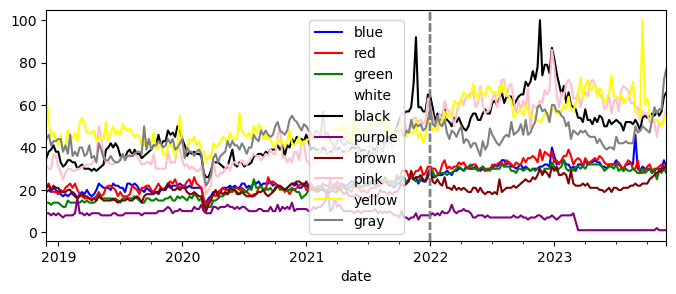

In [5]:
col_list=list(GOTRE_col.columns)

# Convert the date string to a pandas Timestamp
change_date = pd.Timestamp('2022-01-01')
plt.figure(figsize=(8, 3)) 
for i in col_list:
    GOTRE_col[i].plot(color=colors_dict.get(i, 'black'))  # Use black color if not in color_dict
    plt.axvline(x=change_date, color='grey', linestyle='--')

plt.legend()  # Show legend if needed
plt.show()

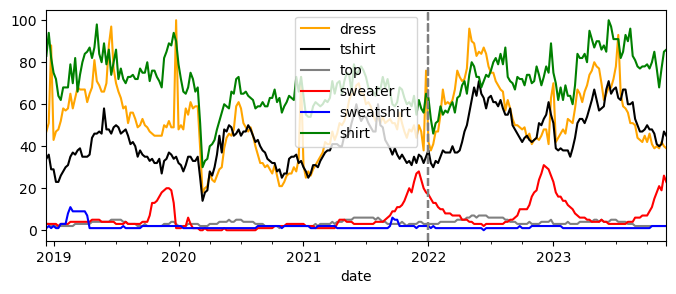

In [6]:
col_list=list(GOTRE_typ.columns)

# Convert the date string to a pandas Timestamp
change_date = pd.Timestamp('2022-01-01')
plt.figure(figsize=(8, 3)) 
for i in col_list:
    GOTRE_typ[i].plot(color=types_dict.get(i, 'black'))  # Use black color if not in color_dict
    plt.axvline(x=change_date, color='grey', linestyle='--')

plt.legend()  
plt.show()


## 4. Eval if there exists a relevant pattern in the time series

Use `lag_plot`to eval if there is a dependent relation between the current moment with previous moments for each color 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


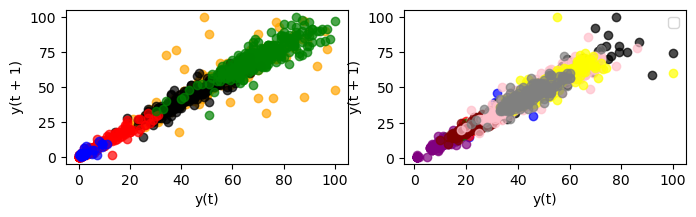

In [7]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(8, 2))  # 1 row, 2 columns for side-by-side plots

col_list=list(GOTRE_typ.columns)
for i in col_list:
    lag_plot(GOTRE_typ[i], c=types_dict.get(i, 'black'), alpha=0.7, ax=axes[0])
plt.legend()  # Show legend if needed

col_list=list(GOTRE_col.columns)
for i in col_list:
    lag_plot(GOTRE_col[i], c=colors_dict.get(i, 'black'), alpha=0.7, ax=axes[1])
plt.legend()  # Show legend if needed

plt.show()


## 5. Auto-regression - seasonal_decompose:

### Get seasonal and Quinquennial patterns- Google Trends data ends in 2023-11-26

In [8]:
import statsmodels.api as sm

trend_type1=pd.DataFrame()
season_type1=pd.DataFrame()

# type clothing
for colum in GOTRE_typ.columns:
    
    res=sm.tsa.seasonal_decompose(GOTRE_typ[colum])

    trend_type = res.trend.interpolate()
    trend_type=pd.DataFrame(trend_type)
    trend_type["type"]=colum

    season_type = res.seasonal
    season_type=pd.DataFrame(season_type)
    season_type['2022-11-26': '2023-11-26'] #take only one year period for seasonal trends
    season_type["type"]=colum
    
    season_type1=pd.concat([season_type, season_type1], axis=0)
    trend_type1=pd.concat([pd.DataFrame(trend_type),trend_type1], axis=0)
    
    
trend_colour1=pd.DataFrame()
season_colour1=pd.DataFrame()

# colour clothing
for colum in GOTRE_col.columns:
    
    res=sm.tsa.seasonal_decompose(GOTRE_col[colum])

    trend_colour = res.trend.interpolate()
    trend_colour=pd.DataFrame(trend_colour)
    trend_colour["colour"]=colum

    season_colour = res.seasonal
    season_colour=pd.DataFrame(season_colour)
    season_colour['2022-11-26': '2023-11-26'] #take only one year period for seasonal trends
    season_colour["colour"]=colum
    
    season_colour1=pd.concat([season_colour, season_colour1], axis=0)
    trend_colour1=pd.concat([pd.DataFrame(trend_colour),trend_colour1], axis=0)


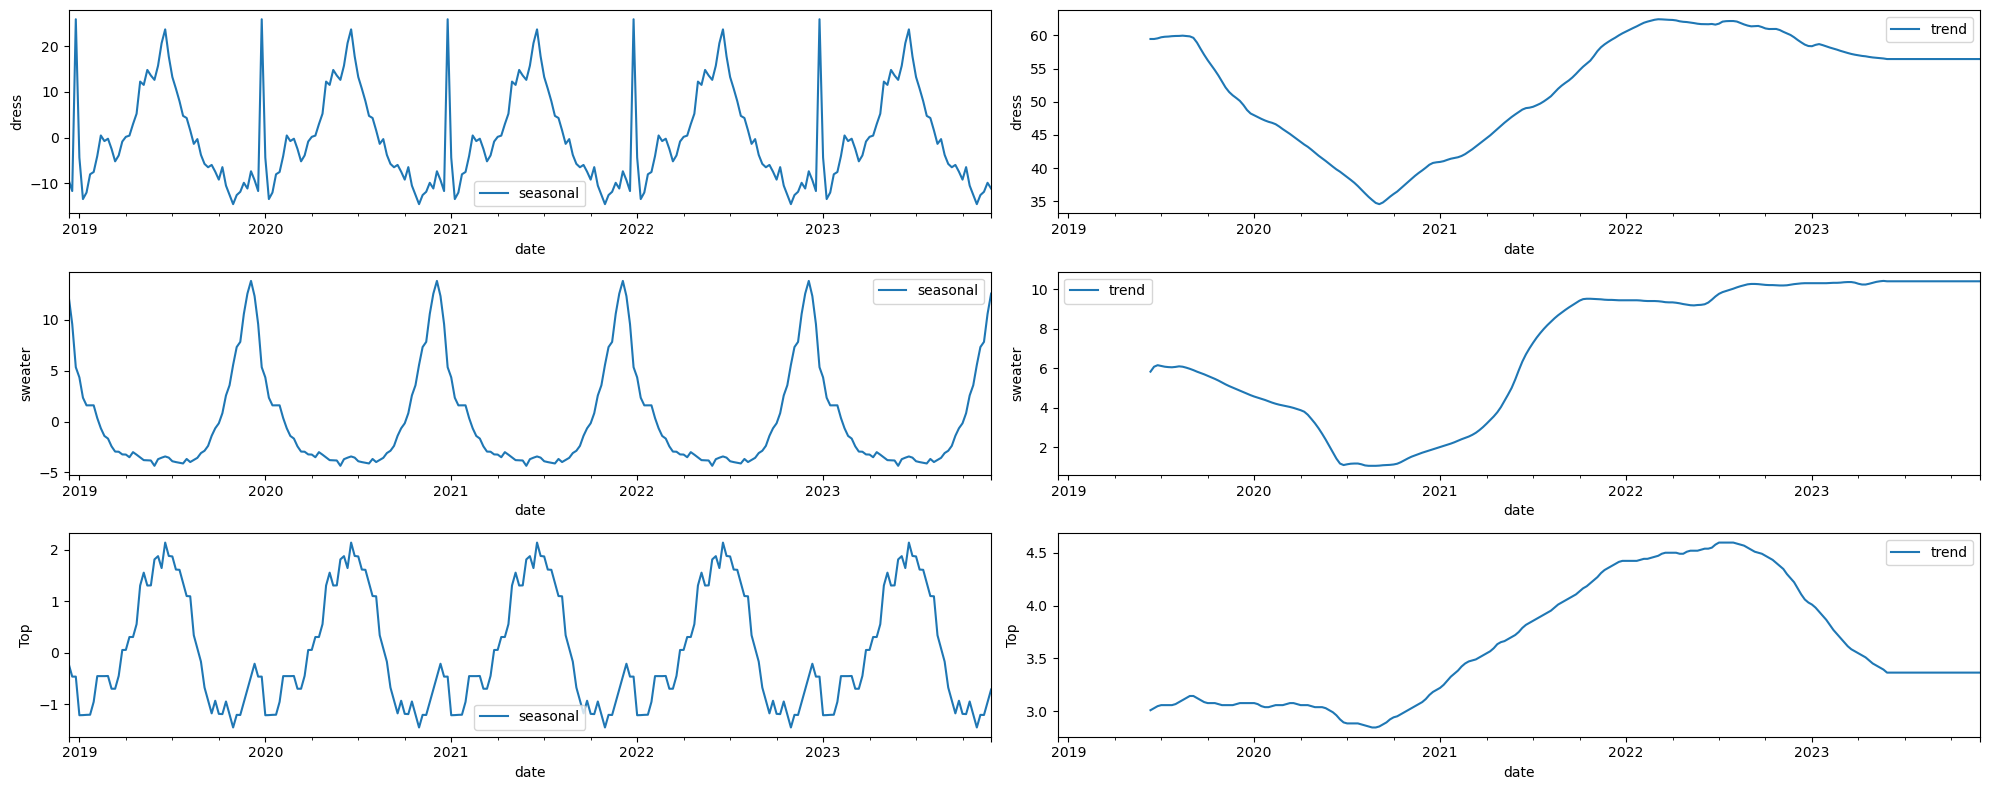

In [9]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(3, 2, figsize=(20, 8))  # 1 row, 2 columns for side-by-side plots

season_type1[season_type1["type"]=="dress"].plot(ax=axes[0,0])
axes[0,0].set_ylabel('dress');

trend_type1[trend_type1["type"]=="dress"].plot(ax=axes[0,1]);
axes[0,1].set_ylabel('dress');

season_type1[season_type1["type"]=="sweater"].plot(ax=axes[1,0])
axes[1,0].set_ylabel('sweater');

trend_type1[trend_type1["type"]=="sweater"].plot(ax=axes[1,1]);
axes[1,1].set_ylabel('sweater');

season_type1[season_type1["type"]=="top"].plot(ax=axes[2,0])
axes[2,0].set_ylabel('Top');

trend_type1[trend_type1["type"]=="top"].plot(ax=axes[2,1]);
axes[2,1].set_ylabel('Top')
plt.tight_layout();


## 6. Auto-regression

### AR Predict `color` and `type` trends 3 weeks ahead - Christmas!!!

In [254]:
# type clothing
trend_type2=trend_type1.copy()

weeks=3
weeks_ind=pd.to_datetime(["2023-12-03", "2023-12-10", "2023-12-17"])

for colum in GOTRE_typ.columns:
    train, test = GOTRE_typ[colum][:-weeks], GOTRE_typ[colum][-weeks:]
    modelo = AR(train, lags=1).fit() # lags=1 es la cadena de Markov, lags son los pasos atras que mira
    pred = modelo.predict(start=len(train), end=len(GOTRE_typ[colum])+ weeks -1)
   
    pred_df=pd.DataFrame(pred) 
    pred_df["type"]=colum
    pred_df.columns=["trend", "type"]
    
    #### error medio absoluto MAE
    #res=pd.DataFrame({'pred': np.array(pred)[:3], 'error': np.array(pred)[:3] - np.array(test)})
    trend_type2=trend_type2.append(pred_df)


In [263]:
#### colour clothing
trend_colour2=trend_colour1.copy()

weeks_start=1
weeks_end=3
weeks_ind=pd.to_datetime(["2023-12-03", "2023-12-10", "2023-12-17"])

for colum in GOTRE_col.columns:
    train, test = GOTRE_col[colum][:-weeks], GOTRE_col[colum][-weeks_start:]
    modelo = AR(train, lags=1).fit() # lags=1 es la cadena de Markov, lags son los pasos atras que mira
    pred = modelo.predict(start=len(train), end=len(GOTRE_col[colum])+ weeks_end -1)
   
    pred_df=pd.DataFrame(pred) 
    pred_df["colour"]=colum
    pred_df.columns=["trend", "colour"]
    
    #### error medio absoluto MAE
    #res=pd.DataFrame({'pred': np.array(pred)[:3], 'error': np.array(pred)[:3] - np.array(test)})
    trend_colour2=trend_colour2.append(pred_df)

### Option 2 - Trying to improve the predictions - Unsuccesfull

**SARIMAX Seasonal AutoRegressive Integrated Moving Average**

SARIMA is more effective than ARIMA for capturing both trends and seasonality in time series data 

In [10]:
#### colour clothing
trend_colour2=trend_colour1.copy()

weeks_start=1
weeks_end=10
weeks_ind=pd.to_datetime(["2023-12-03", "2023-12-10", "2023-12-17"])

for colum in GOTRE_col.columns:
    train, test = GOTRE_col[colum][:-weeks_start], GOTRE_col[colum][-weeks_start:]
    
    modelo=SARIMAX(endog=train, 
               exog=None,
               #order=(4, 1, 5),  # modelo arima
               seasonal_order=(4, 1, 5, 2) # modelo sarima, estacionalidad es el ultimo
              ).fit(disp=False)
    pred = modelo.predict(start=len(train), end=len(GOTRE_col[colum])+ weeks_end -1)
   
    pred_df=pd.DataFrame(pred) 
    pred_df["colour"]=colum
    pred_df.columns=["trend", "colour"]
    
    #### error medio absoluto MAE
    #res=pd.DataFrame({'pred': np.array(pred)[:3], 'error': np.array(pred)[:3] - np.array(test)})
    trend_colour2=trend_colour2.append(pred_df)
    

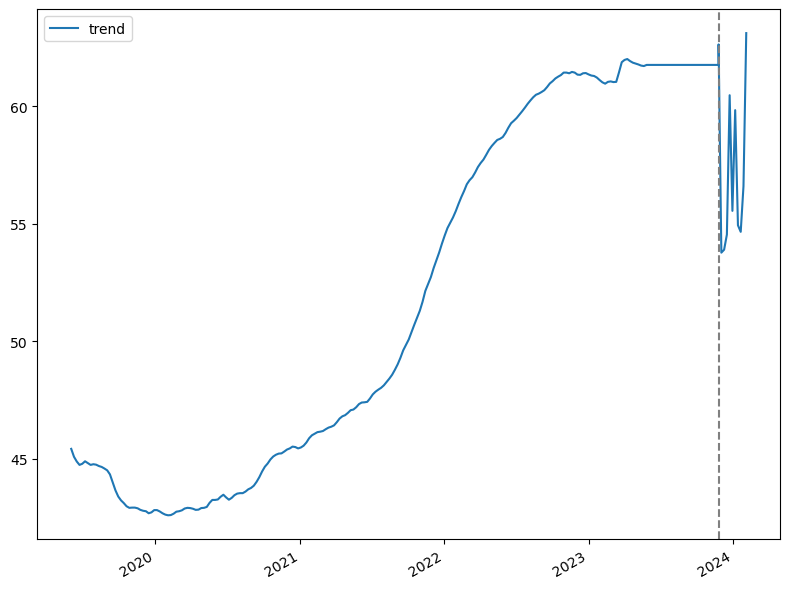

In [11]:
present_date = pd.Timestamp('2023-11-26')

trend_colour2[trend_colour2["colour"]=="yellow"].plot();
plt.axvline(x=present_date, color='grey', linestyle='--')
plt.tight_layout();

## 7. Save seasonal and quinquenial trends 

In [ ]:
clothes_complete=pd.read_csv("../data/clean/clothes_complete.csv")

In [259]:
#season_colour1.to_csv('../data/clean/gootrend_season_col.csv')
#season_type1.to_csv('../data/clean/gootrend_season_typ.csv')

#trend_colour2.to_csv('../data/clean/gootrend_quinq_pred_col.csv')
#trend_type2.to_csv('../data/clean/gootrend_quinq_pred_typ.csv')

#trend_colour1.to_csv('../data/clean/gootrend_quinq_col.csv')
#trend_type1.to_csv('../data/clean/gootrend_quinq_typ.csv')

In [289]:
#with pd.ExcelWriter('../data/clean/clothes_trends.xlsx') as writer:
    clothes_complete.to_excel(writer, sheet_name='clothes', index=False)
    
    trend_type1.to_excel(writer, sheet_name='quinq_type')
    trend_colour1.to_excel(writer, sheet_name='quinq_colour')
    
    season_type1.to_excel(writer, sheet_name='season_type')
    season_colour1.to_excel(writer, sheet_name='season_colour')
